In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39949")
client

<Client: 'tcp://127.0.0.1:39949' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os.path as op

from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset

import gcm_filters

import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/NA-wavelets/'
diag = '/tank/spectre/tuchida/diagnostics/'
# tdgs = '/tank/tdgs/tuchida/TWA/'
spec = '/tank/spectre/tuchida/NA-wavelets/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0
sreg = ['A','B','C','D','E','F']

xo = 50e3
ntheta = 36

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

In [7]:
iiter = 1419120
# iiter = 1421280
# iiter = 1423440

dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(
                           # YC=slice(15-dg/12,50+dg/12),
                           # YG=slice(15-dg/12,50+dg/12),
                           # XC=slice(273-dg/12,330+dg/12),
                           # XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
dsb

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46)
Coordinates: (12/33)
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    THETA    (Z, YC, XC) >f4 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    SALT     (Z, YC, XC) >f4 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    UVEL     (Z, YC, XG) >f4 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    VVEL     (Z, YG, XC) >f4 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    WVEL     (Zl, YC, XC) >f4 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
# reg = 3
dg = 1
nmembs = np.arange(100,148)
    
for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                            ).sel(
                                  # YC=slice(15-dg/12,50+dg/12),
                                  # YG=slice(15-dg/12,50+dg/12),
                                  # XC=slice(273-dg/12,330+dg/12),
                                  # XG=slice(273-dg/12,330+dg/12)
                                 ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                    % (nmemb)), 
                                            grid_dir=gdir,
                                            prefix=['snap_diagOcn'], delta_t=2e2,
                                            iters=iiter, 
                                           ).sel(
                                                 # YC=slice(15-dg/12,50+dg/12),
                                                 # YG=slice(15-dg/12,50+dg/12),
                                                 # XC=slice(273-dg/12,330+dg/12),
                                                 # XG=slice(273-dg/12,330+dg/12)
                                                ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                       ).isel(time=0)
                       ], dim='nmemb')

# if len(dsb.XG) > len(dsb.XC):
#      dsb = dsb.isel(XG=slice(None,-1))
# elif len(dsb.XG) < len(dsb.XC):
#      dsb = dsb.isel(XC=slice(1,None))  
# if len(ds.XG) > len(ds.XC):
#      ds = ds.isel(XG=slice(None,-1))
# elif len(ds.XG) < len(ds.XC):
#      ds = ds.isel(XC=slice(1,None))  
# if len(dsb.YG) > len(dsb.YC):
#      dsb = dsb.isel(YG=slice(None,-1))
# if len(ds.YG) > len(ds.YC):
#      ds = ds.isel(YG=slice(None,-1))
        
ds.coords['nmemb'] = ('nmemb',nmembs)

ub = dsb.UVEL
vb = dsb.VVEL
u = ds.UVEL
v = ds.VVEL
up = u - ub
vp = v - vb

grid = Grid(ds, periodic=[])
coords={'X':{'center':'XC', 'left':'XG'}, 
        'Y':{'center':'YC', 'left':'YG'}}
gridz = Grid(ds.isel(Z=[0,18],Zu=[0,18],Zl=[0,18]), 
             periodic=['X'], coords=coords)
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, nmemb: 48)
Coordinates: (12/34)
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [12]:
# grid info centered at T-points
wet_mask_t = ds.maskC.isel(Z=[0,18])
# wet_mask_t[dict(XC=-1)] = 0.
# wet_mask_t[dict(XC=0)] = 0.
wet_mask_t[dict(YC=-1)] = 0.
wet_mask_t[dict(YC=0)] = 0.

# grid info centered at vorticity points
wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                        ).isel(Z=[0,18]).swap_dims({"XG": "XC", "YG": "YC"})
# wet_mask_q[dict(XC=-1)] = 0.
# wet_mask_q[dict(XC=0)] = 0.
wet_mask_q[dict(YC=-1)] = 0.
wet_mask_q[dict(YC=0)] = 0.

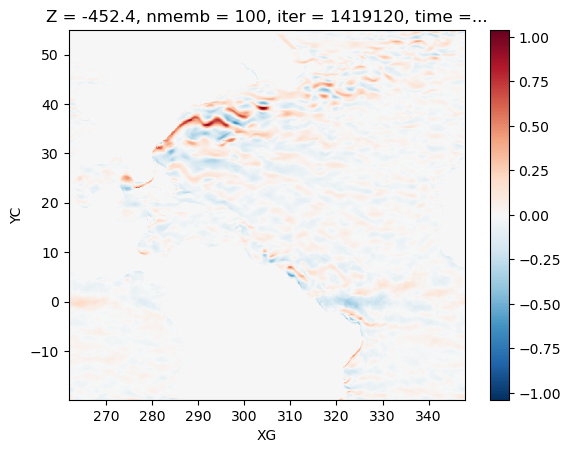

20000.0


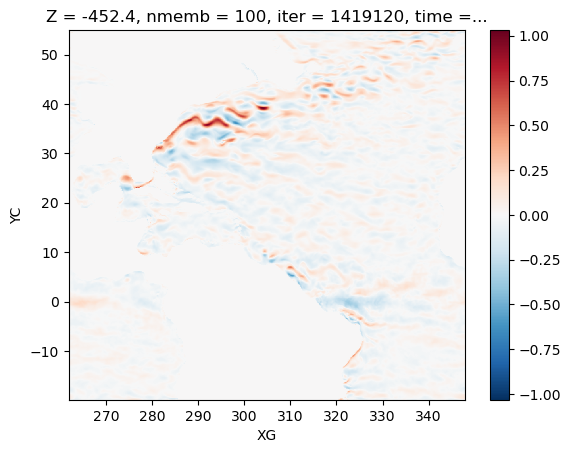

25000.0


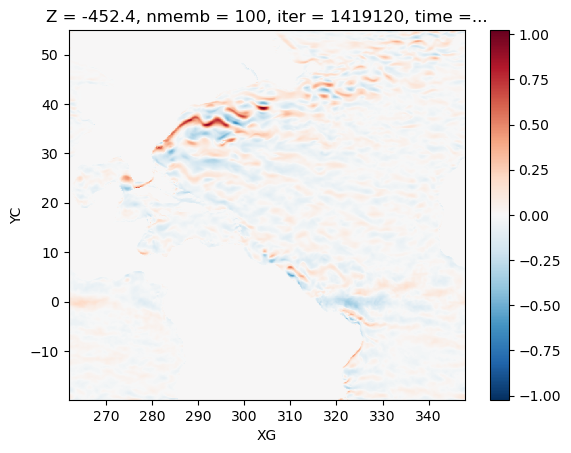

30000.0


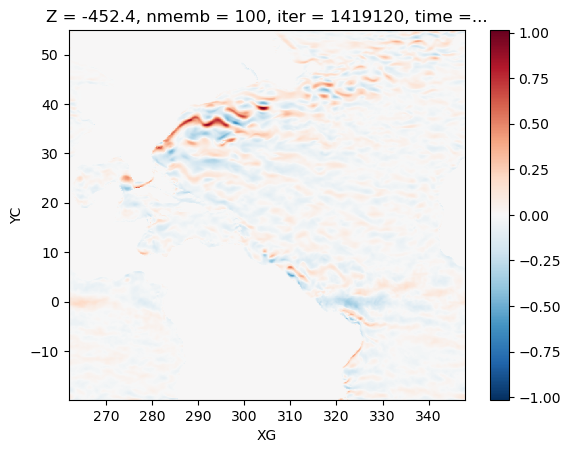

35000.0


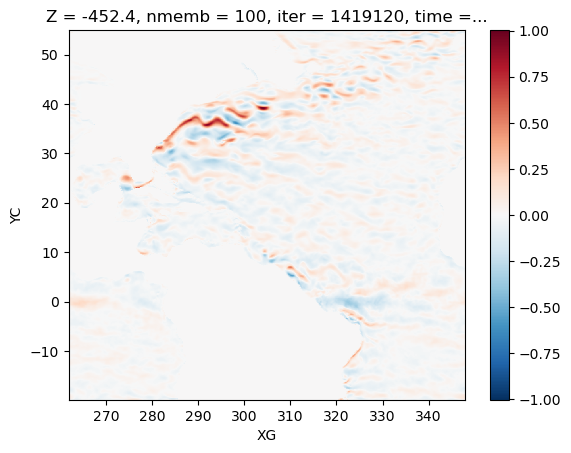

40000.0


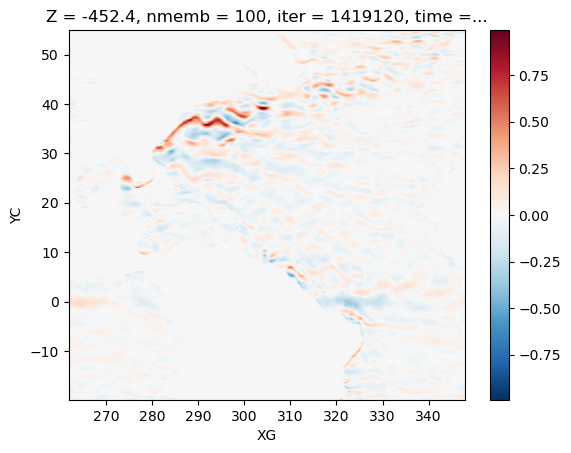

45000.0


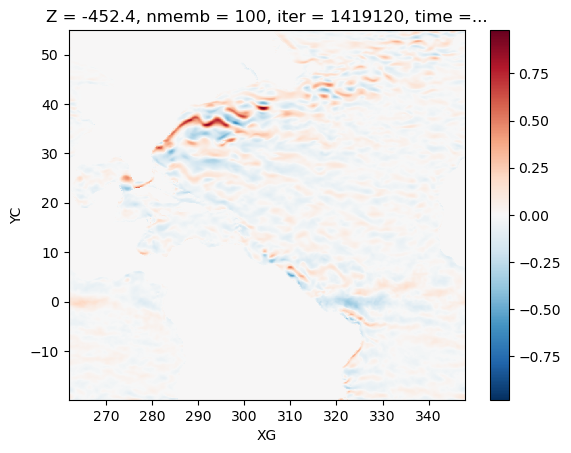

50000.0


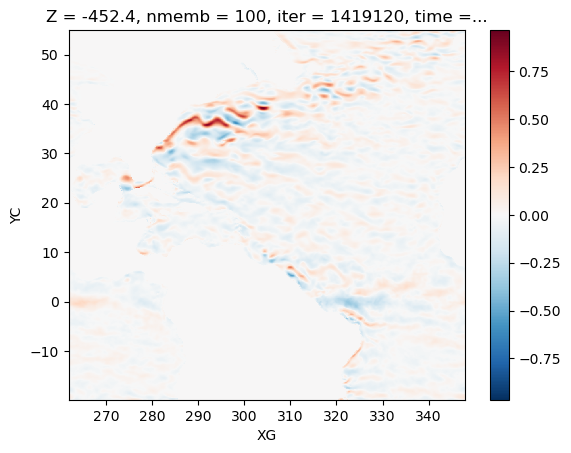

55000.0


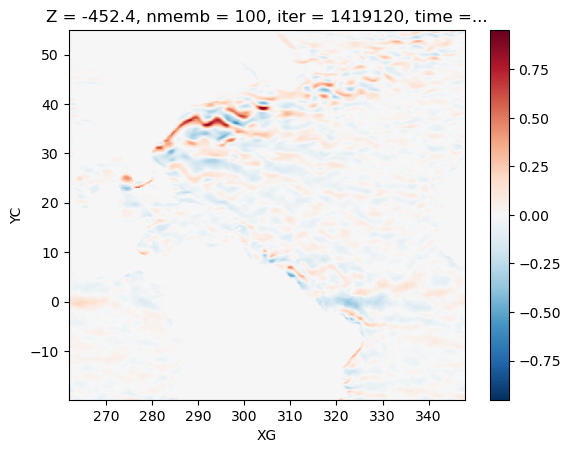

60000.0


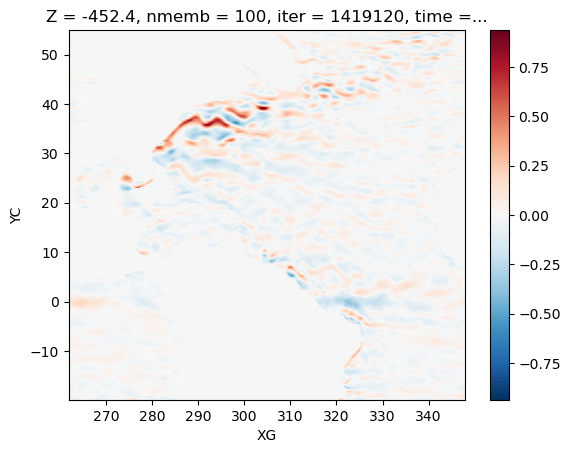

65000.0


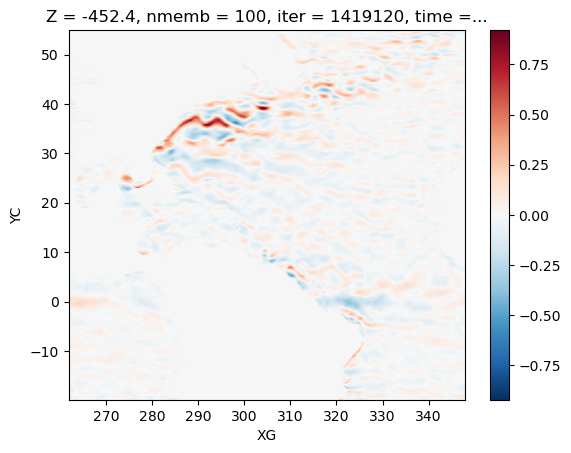

70000.0


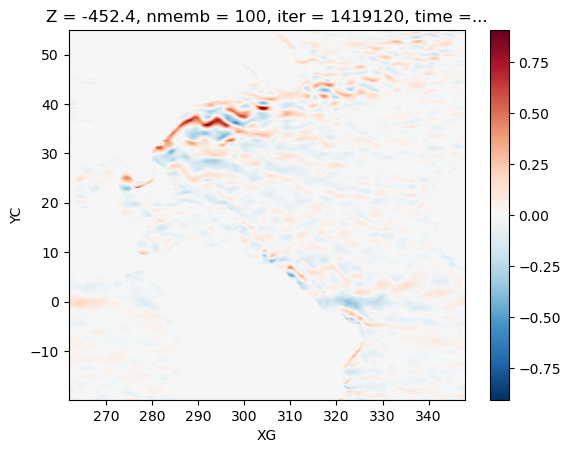

75000.0


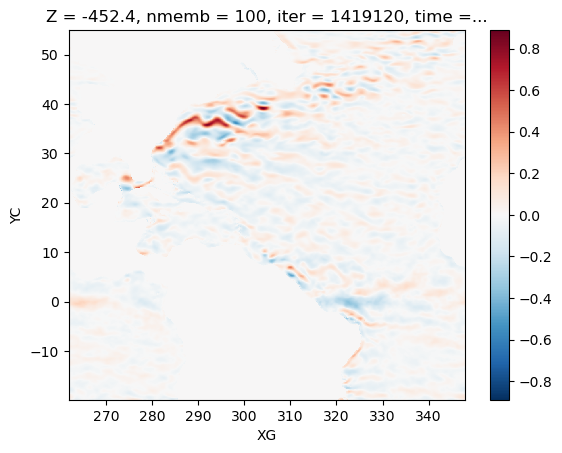

80000.0


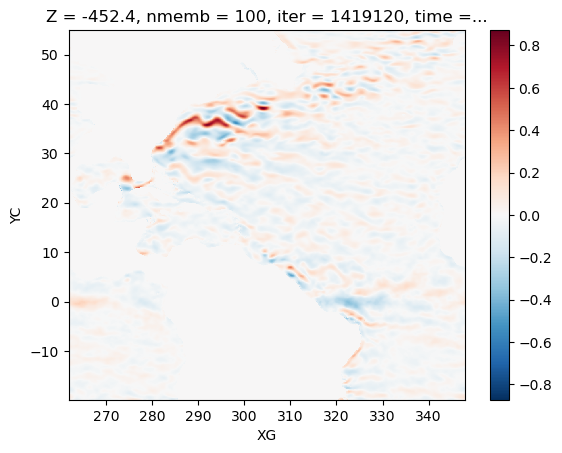

85000.0


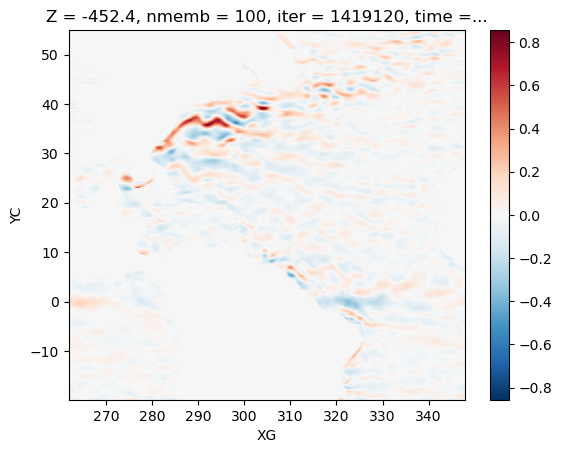

90000.0


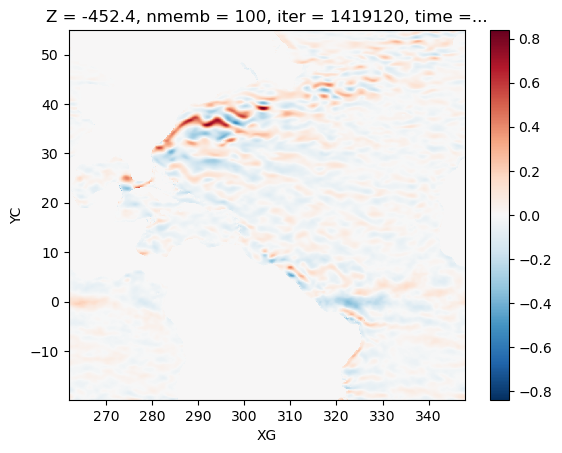

95000.0


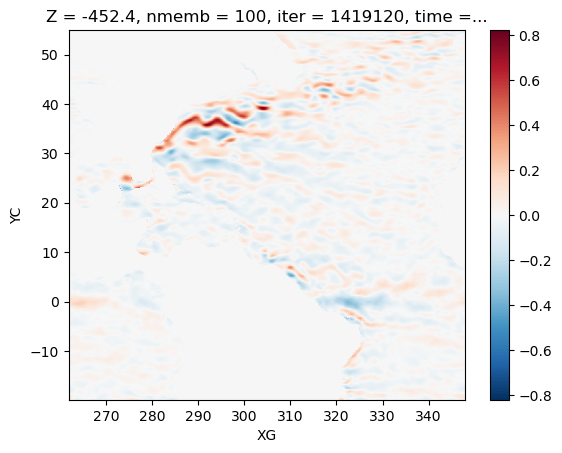

100000.0


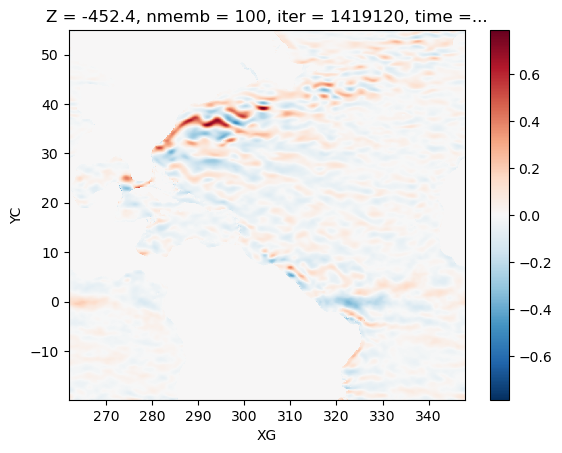

110000.0


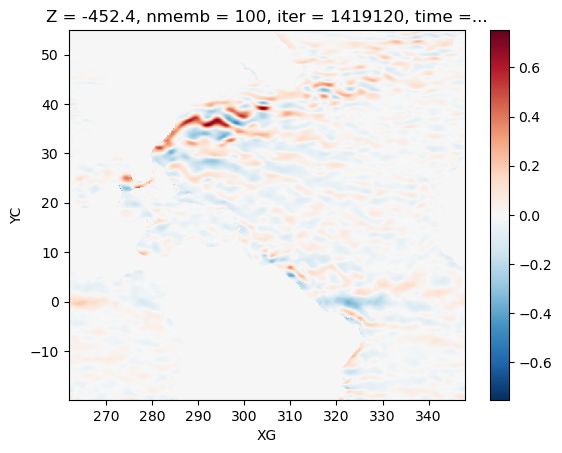

120000.0


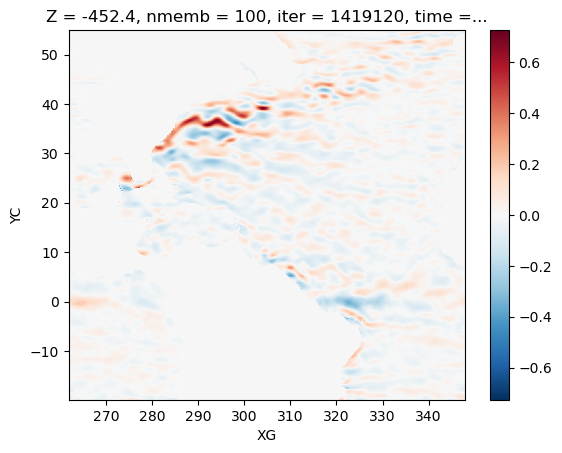

130000.0


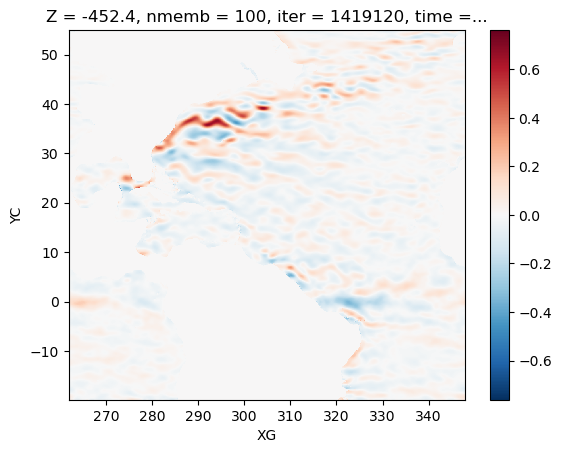

140000.0


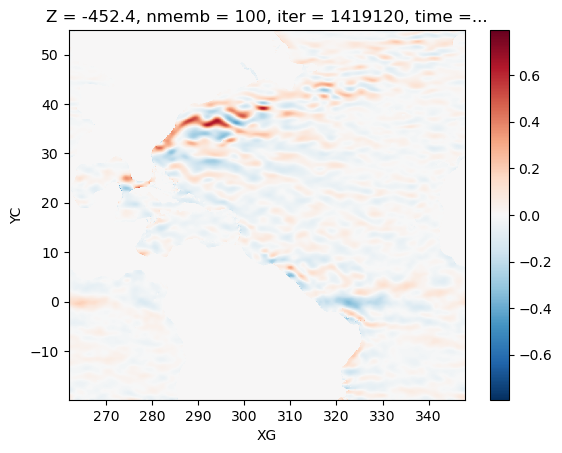

150000.0


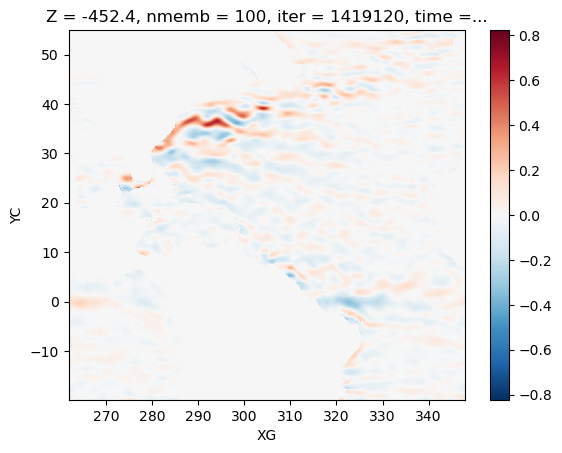

160000.0


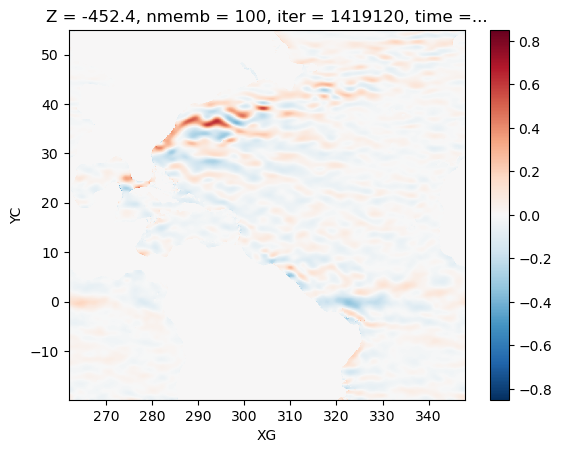

170000.0


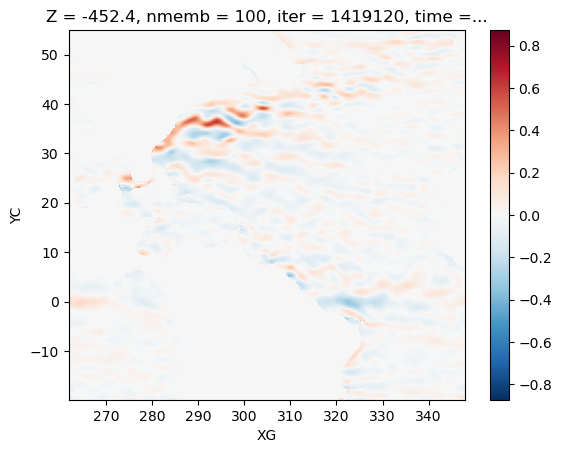

180000.0


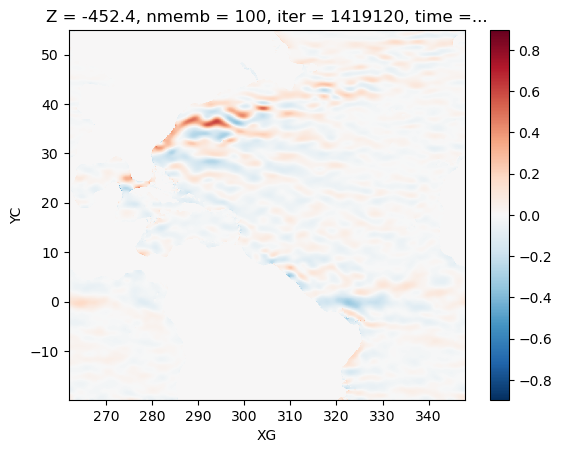

190000.0


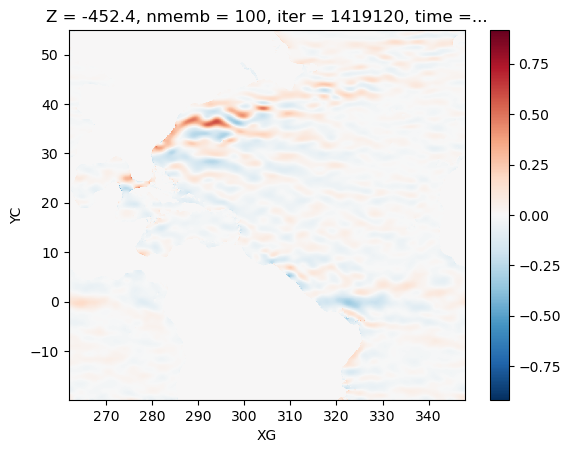

200000.0


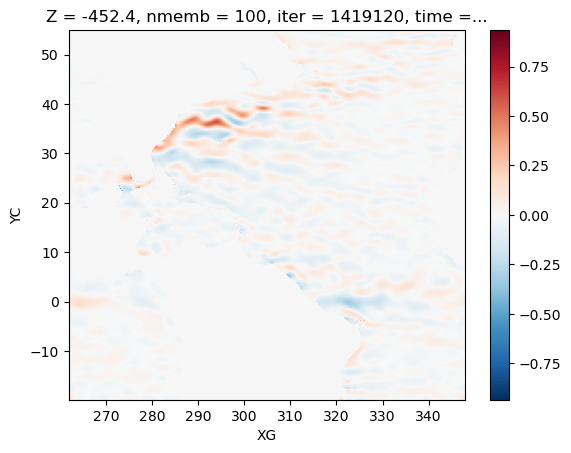

210000.0


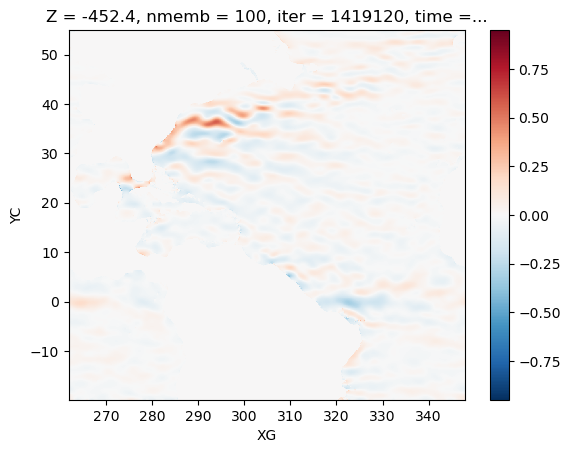

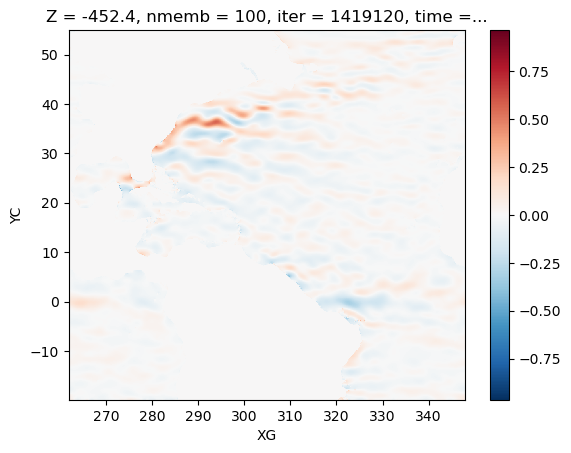

230000.0


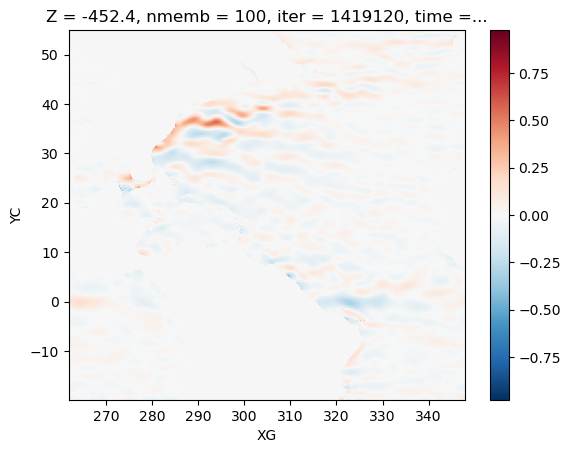

240000.0


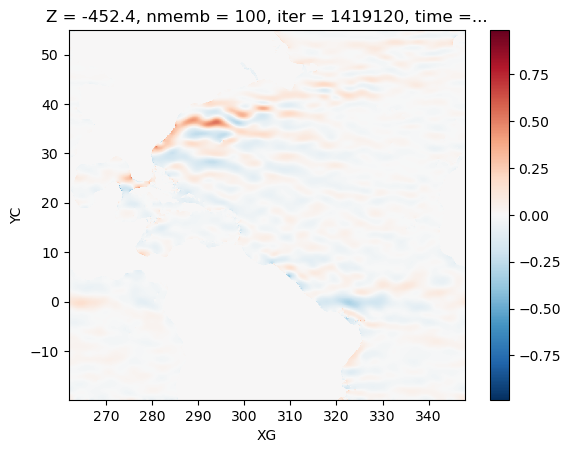

250000.0


In [10]:
dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
dyT = grid.interp(ds.dyG, 'X', 
                  # boundary='extend'
                 )
# grid info centered at U-points
dxCu = ds.dxC.swap_dims({"XG": "XC"})
dyCu = ds.dyG.swap_dims({"XG": "XC"})
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds.dxG.swap_dims({"YG": "YC"})
dyCv = ds.dyC.swap_dims({"YG": "YC"})
area_v = dxCv * dyCv

dxBu = grid.interp(ds.dxC,'Y',boundary='extend').swap_dims({"XG": "XC", "YG": "YC"})
dyBu = grid.interp(ds.dyC,'X',
                   # boundary='extend'
                  ).swap_dims({"XG": "XC", "YG": "YC"})

dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values

# dx_max = max(dxT.max(), dyT.max(), dxCu.max(), dyCu.max(), 
#              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
# dx_max = dx_max.values

kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

for filter_scale in np.concatenate((np.arange(20e3,100e3,5e3),
                                    np.arange(100e3,260e3,10e3))):
    
    filter_visc = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.VECTOR_C_GRID,
        grid_vars={
            'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
            'dxT': dxT, 'dyT': dyT, 
            'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
            'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
            'dxBu': dxBu, 'dyBu': dyBu,
            'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
        }
    )
    
    # U  = u.swap_dims({'XG':'XC'}).reset_coords(drop=True)
    # V  = v.swap_dims({'YG':'YC'}).reset_coords(drop=True)
    ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
    ds_tmp['u'] = u.isel(Z=[0,18])
    ds_tmp['v'] = v.isel(Z=[0,18])
    ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
    ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
    (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                           dims=['YC', 'XC'])
    u_filtered = u_filtered.swap_dims({"XC":"XG"}).isel(
        # XG=slice(1,-1),
        YC=slice(1,-1))
    v_filtered = v_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),
                                                        # XC=slice(1,-1)
                                                       )
    ds_tmp.close()
    
    u_filtered.isel(nmemb=0,Z=1).plot(rasterized=True)
    plt.show()
    # Ub = ub.swap_dims({'XG':'XC'}).reset_coords(drop=True)
    # Vb = vb.swap_dims({'YG':'YC'}).reset_coords(drop=True)
    ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
    ds_tmp['U'] = ub.isel(Z=[0,18])
    ds_tmp['V'] = vb.isel(Z=[0,18])
    ds_tmp['U'] = ds_tmp['U'].swap_dims({'XG':'XC'})
    ds_tmp['V'] = ds_tmp['V'].swap_dims({'YG':'YC'})
    (U_filtered, V_filtered) = filter_visc.apply_to_vector(ds_tmp.U, ds_tmp.V, 
                                                           dims=['YC', 'XC'])
    ub_filtered = U_filtered.swap_dims({"XC":"XG"})
    vb_filtered = V_filtered.swap_dims({"YC":"YG"})
    ds_tmp.close()
    # Up = up.swap_dims({'XG':'XC'})
    # Vp = vp.swap_dims({'YG':'YC'})
    
    
    dsave = u_filtered.reset_coords(drop=True).to_dataset(name="u")
    dsave.chunk({'YC':ychunk,'XG':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    dsave = v_filtered.reset_coords(drop=True).to_dataset(name='v')
    dsave.chunk({'YG':ychunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    dsave = ub_filtered.to_dataset(name='U')
    dsave["V"] = vb_filtered
    dsave.chunk({'YG':ychunk,'YC':ychunk,
                 'XG':xchunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    print(filter_scale)

In [7]:
def hori_advec_um(ds, u, cori=False, metr=False):

    '''
    Compute the 3D advection and advective fluxes
    of zonal momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Um, ADVy_Um, ADVrE_Um: zonal, meridional and vertical u-momentum flux
       - Um_Advec: u-momentum flux divergence.
                   In MITgcm diagnostics, Um_Advec also includes 
                   Coriolis (Um_Cori) and metric term (Um_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAw = ds.rAw
    uuu = ds.UVEL.data
    vvv = ds.VVEL.data
    # www = ds.WVEL.data
    #
    xA = (drF * dyG * hW).data
    yA = (drF * dxG * hS).data
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    
    grid = Grid(ds, periodic=['X'])

    #-- get and check dimensions --
    [nr, ny, nx] = hW.shape
    tmp = nr*ny*nx
    # if np.size(u)!=np.size(vvv) or np.size(u)!=np.size(ds.WVEL) or np.size(u)!=tmp:
    #     raise ValueError("advec_um: velocity field do not have the same/right dimension")
    #

    #-- zonal advective flux of U (from mom_u_adv_uu.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    ADVx_Um = np.zeros_like(hW.data)
    ADVx_Um[:, :, :-1] = \
            0.25 *(uTrans[:, :, :-1] + uTrans[:, :, 1:] ) \
                 *(   u[:, :, :-1] +    u[:, :, 1:]   )
    
    #-- meridional advective flux of U (from mom_u_adv_vu.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    ADVy_Um = np.zeros_like(hW.data)
    ADVy_Um[:, 1:, 1:] = \
            0.25 *(vTrans[:, 1:, 1:] + vTrans[:, 1:, :-1] ) \
                 *(   u[:, 1:, 1:] +    u[:, :-1, 1:]   )
    
    # #-- vertical advective flux of U (from mom_u_adv_wu.F) --
    # #- transport -
    # # rTransU :: vertical transport (above U point) 
    # rTransU = np.zeros_like(hW.data)
    # rTransU[:, :, 1:] = \
    #         0.5 * ( www[:, :, :-1] * rA.data[np.newaxis, :, :-1] \
    #                +www[:, :, 1: ] * rA.data[np.newaxis, :, 1: ] )
    # #- advective flux -
    # # surface layer 
    # ADVrE_Um = np.zeros_like(hW.data)
    # ADVrE_Um[0, :, :] = rTransU[0, :, :] * u[0, :, :]
    # #ADVrE_Um[0, :, :] = 0.0         # rigid lid, for checking
    # # interior flux
    # ADVrE_Um[1:, :, :] = rTransU[1:, :, :] * \
    #         0.5 * ( u[1:, :, :] + u[:-1, :, :])
    # # (linear) Free-surface correction at k>1
    # ADVrE_Um[1:, :, 1:] = ADVrE_Um[1:, :, 1:] \
    #         + 0.25 * (\
    #           www[1:, :, 1:] * rA.data[np.newaxis, :, 1:] *\
    #             (maskC[1:, :, 1:] - maskC[:-1, :, 1:]) \
    #          +www[1:, :, :-1] * rA.data[np.newaxis, :, :-1] *\
    #             (maskC[1:, :, :-1] - maskC[:-1, :, :-1]) \
    #                  ) * u[1:, :, 1:]
        
    
    #-- flux divergence (from mom_fluxform.F) --
    #- zonal -
    gUx = np.zeros_like(hW.data)
    gUx[:, :, 1:] = - 1 / (hW * drF * rAw).data[:, :, 1:] \
            * (ADVx_Um[:, :, 1:] - ADVx_Um[:, :, :-1])
    #- meridional -
    gUy = np.zeros_like(hW.data)
    gUy[:, :-1, :] = - 1 / (hW * drF * rAw).data[:, :-1, :] \
            * (ADVy_Um[:, 1:, :] - ADVy_Um[:, :-1, :])
    # #- vertical -
    # gUz = np.zeros_like(hW.data)
    # gUz[:-1, :, :] = - 1 / (hW * drF * rAw).data[:-1, :, :] \
    #         * (ADVrE_Um[:-1, :, :] - ADVrE_Um[1:, :, :])
    # gUz[-1, :, :] = - 1 / (hW * drF * rAw).data[-1, :, :] \
    #         * (ADVrE_Um[-1, :, :] - 0.0)     #no bottom flux at bottom cell
    if cori:
        print("Include Coriolis and metric terms in Um_Advec (following MITgcm diagnostic package convention)")
        print("TO BE DONE (07/21/2023)")
    #- total -
    Um_Advec = xr.DataArray(gUx + gUy, dims=ds.UVEL.dims, coords=ds.UVEL.coords
                           ).reset_coords(drop=True)

    return (Um_Advec, 
            (ADVx_Um
             / grid.interp(drF * dyG * hW,'X')
            ).reset_coords(drop=True), 
            (ADVy_Um
             / grid.interp(drF * dxG * hS,'X')
            ).reset_coords(drop=True))


def hori_advec_vm(ds, v, cori=False, metr=False):

    '''
    Compute the 3D advection and advective fluxes
    of meridional momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Vm, ADVy_Vm, ADVrE_Vm: zonal, meridional and vertical v-momentum flux
       - Vm_Advec: v-momentum flux divergence.
                   In MITgcm diagnostics, Vm_Advec also includes 
                   Coriolis (Vm_Cori) and metric term (Vm_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAs = ds.rAs
    uuu = ds.UVEL.data
    vvv = ds.VVEL.data
    # www = ds.WVEL.data
    #
    xA = (drF * dyG * hW).data
    yA = (drF * dxG * hS).data
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    
    grid = Grid(ds, periodic=['X'])

    #-- get and check dimensions --
    [nr, ny, nx] = hS.shape
    tmp = nr*ny*nx
    # if np.size(uuu)!=np.size(v) or np.size(v)!=np.size(ds.WVEL) or np.size(v)!=tmp:
    #     raise ValueError("advec_vm: velocity field do not have the same/right dimension")
    #
    
    #-- zonal advective flux of V (mom_v_adv_uv.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    ADVx_Vm = np.zeros_like(hS.data)
    ADVx_Vm[:, 1:, 1:] = \
        0.25 *(uTrans[:, 1:, 1:] + uTrans[:, :-1, 1:] ) \
             *(   v[:, 1:, 1:] + v[:, 1:, :-1]    )

    #-- meridional advective flux of V (from mom_v_adv_vv.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    ADVy_Vm = np.zeros_like(hS.data)
    ADVy_Vm[:, :-1, :] = \
            0.25 *(vTrans[:, :-1, :] + vTrans[:, 1:, :] ) \
                 *(   v[:, :-1, :] + v[:, 1:, :]   )

    # #-- vertical advective flux of V (mom_v_adv_wv.F) --
    # #- transport -
    # # rTransV :: vertical transport (above V point) 
    # rTransV = np.zeros_like(hS.data)
    # rTransV[:, 1:, :] = \
    #         0.5 * ( www[:, :-1, :] * rA.data[np.newaxis, :-1, :] \
    #                +www[:, 1: , :] * rA.data[np.newaxis, 1: , :] )
    # #- advective flux -
    # # surface layer 
    # ADVrE_Vm = np.zeros_like(hS.data)
    # ADVrE_Vm[0, :, :] = rTransV[0, :, :] * v[0, :, :]
    # #ADVrE_Vm[0, :, :] = 0.0         # rigid lid, for checking
    # # interior flux
    # ADVrE_Vm[1:, :, :] = rTransV[1:, :, :] * \
    #         0.5 * ( v[1:, :, :] + v[:-1, :, :])
    # # (linear) Free-surface correction at k>1
    # ADVrE_Vm[1:, 1:, :] = ADVrE_Vm[1:, 1:, :] \
    #         + 0.25 * (\
    #           www[1:, 1:, :] * rA.data[np.newaxis, 1:, :] *\
    #             (maskC[1:, 1:, :] - maskC[:-1, 1:, :]) \
    #          +www[1:, :-1, :] * rA.data[np.newaxis, :-1, :] *\
    #             (maskC[1:, :-1, :] - maskC[:-1, :-1, :]) \
    #                  ) * v[1:, 1:, :]

    #-- flux divergence (mom_fluxform.F) --
    #- zonal -
    gVx = np.zeros_like(hS.data)
    gVx[:, :, :-1] = - 1 / (hS * drF * rAs).data[:, :, :-1] \
            * (ADVx_Vm[:, :, 1:] - ADVx_Vm[:, :, :-1])
    #- meridional -
    gVy = np.zeros_like(hS.data)
    gVy[:, 1:, :] = - 1 / (hS * drF * rAs).data[:, 1:, :] \
            * (ADVy_Vm[:, 1:, :] - ADVy_Vm[:, :-1, :])
    # #- vertical -
    # gVz = np.zeros_like(hS.data)
    # gVz[:-1, :, :] = - 1 / (hS * drF * rAs).data[:-1, :, :] \
    #         * (ADVrE_Vm[:-1, :, :] - ADVrE_Vm[1:, :, :])
    # gVz[-1, :, :] = - 1 / (hS * drF * rAs).data[-1, :, :] \
    #         * (ADVrE_Vm[-1, :, :] - 0.0)     #no bottom flux at bottom cell
    if cori:
        print("Include Coriolis and metric terms in Vm_Advec (following MITgcm diagnostic package convention)")
        print("TO BE DONE (07/21/2023)")
    #- total -
    Vm_Advec = xr.DataArray(gVx + gVy, dims=ds.VVEL.dims, coords=ds.VVEL.coords
                           ).reset_coords(drop=True)

    return (Vm_Advec, 
            (ADVx_Vm 
             / grid.interp(drF * dyG * hW,'Y',boundary='extend')
            ).reset_coords(drop=True), 
            (ADVy_Vm 
             / grid.interp(drF * dxG * hS,'Y',boundary='extend')
            ).reset_coords(drop=True))

In [6]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 3  # 
yystart = 0
ntimes[yystart,dd:][::3]

array([1425600, 1432080, 1438560, 1445040, 1451520, 1458000, 1464480,
       1470960, 1477440, 1483920, 1490400, 1496880, 1503360, 1509840,
       1516320, 1522800, 1529280, 1535760, 1542240, 1548720, 1555200,
       1561680, 1568160, 1574640])

In [7]:
nmembs = np.arange(100,148)
dg = 1

for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(15-dg/12,50+dg/12),
                                      # YG=slice(15-dg/12,50+dg/12),
                                      # XC=slice(273-dg/12,330+dg/12),
                                      # XG=slice(273-dg/12,330+dg/12)
                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(
                                                     # YC=slice(15-dg/12,50+dg/12),
                                                     # YG=slice(15-dg/12,50+dg/12),
                                                     # XC=slice(273-dg/12,330+dg/12),
                                                     # XG=slice(273-dg/12,330+dg/12)
                                                    ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                           ).isel(time=0)
                           ], dim='nmemb')

    # if len(dsb.XG) > len(dsb.XC):
    #      dsb = dsb.isel(XG=slice(None,-1))
    # elif len(dsb.XG) < len(dsb.XC):
    #      dsb = dsb.isel(XC=slice(1,None))  
    # if len(ds.XG) > len(ds.XC):
    #      ds = ds.isel(XG=slice(None,-1))
    # elif len(ds.XG) < len(ds.XC):
    #      ds = ds.isel(XC=slice(1,None))  
    # # if len(dsb.YG) > len(dsb.YC):
    # #      dsb = dsb.isel(YG=slice(None,-1))
    # # if len(ds.YG) > len(ds.YC):
    # #      ds = ds.isel(YG=slice(None,-1))

    ds.coords['nmemb'] = ('nmemb',nmembs)

    ub = dsb.UVEL
    vb = dsb.VVEL
    u = ds.UVEL
    v = ds.VVEL
    up = u - ub
    vp = v - vb

    grid = Grid(ds, periodic=['X'])
    
    if iiter == ntimes[0,dd]:
        # grid info centered at T-points
        wet_mask_t = ds.maskC.isel(Z=[18])
        # wet_mask_t[dict(XC=-1)] = 0.
        # wet_mask_t[dict(XC=0)] = 0.
        wet_mask_t[dict(YC=-1)] = 0.
        wet_mask_t[dict(YC=0)] = 0.

        # grid info centered at vorticity points
        wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                                ).isel(Z=[18]).swap_dims({"XG": "XC", "YG": "YC"})
        # wet_mask_q[dict(XC=-1)] = 0.
        # wet_mask_q[dict(XC=0)] = 0.
        wet_mask_q[dict(YC=-1)] = 0.
        wet_mask_q[dict(YC=0)] = 0.
    
        dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
        dyT = grid.interp(ds.dyG, 'X', 
                          # boundary='extend'
                         )
        # grid info centered at U-points
        dxCu = ds.dxC.swap_dims({"XG": "XC"})
        dyCu = ds.dyG.swap_dims({"XG": "XC"})
        area_u = dxCu * dyCu
        # grid info centered at V-points
        dxCv = ds.dxG.swap_dims({"YG": "YC"})
        dyCv = ds.dyC.swap_dims({"YG": "YC"})
        area_v = dxCv * dyCv

        dxBu = grid.interp(ds.dxC,'Y',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})
        dyBu = grid.interp(ds.dyC,'X',
                           # boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})

        # dx_max = max(dxT.max() , dyT.max() , dxCu.max(), dyCu.max(), 
        #              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
        # dx_max = dx_max.values

        kappa_iso = xr.ones_like(dxT)
        kappa_aniso = xr.zeros_like(dyT)
        
    dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
    dx_min = dx_min.values
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    # for filter_scale in np.arange(scale_min,20e3,5e3):
    for filter_scale in np.concatenate((np.arange(scale_min,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):
    
        filter_visc = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.VECTOR_C_GRID,
            grid_vars={
                'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
                'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
                'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
                'dxBu': dxBu, 'dyBu': dyBu,
                'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
            }
        )

        # U  = u.swap_dims({'XG':'XC'}).reset_coords(drop=True)
        # V  = v.swap_dims({'YG':'YC'}).reset_coords(drop=True)
        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['u'] = u.isel(Z=[18])
        ds_tmp['v'] = v.isel(Z=[18])
        ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
        ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
        (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                               dims=['YC', 'XC'])
        u_filtered = u_filtered.swap_dims({"XC":"XG"}).isel(
            # XG=slice(1,-1),
            YC=slice(1,-1))
        v_filtered = v_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),
                                                            # XC=slice(1,-1)
                                                           )
        ds_tmp.close()

        # u_filtered.isel(nmemb=0,Z=1).plot(rasterized=True)
        # plt.show()
        # Ub = ub.swap_dims({'XG':'XC'}).reset_coords(drop=True)
        # Vb = vb.swap_dims({'YG':'YC'}).reset_coords(drop=True)
        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['U'] = ub.isel(Z=[18])
        ds_tmp['V'] = vb.isel(Z=[18])
        ds_tmp['U'] = ds_tmp['U'].swap_dims({'XG':'XC'})
        ds_tmp['V'] = ds_tmp['V'].swap_dims({'YG':'YC'})
        (U_filtered, V_filtered) = filter_visc.apply_to_vector(ds_tmp.U, ds_tmp.V, 
                                                               dims=['YC', 'XC'])
        ub_filtered = U_filtered.swap_dims({"XC":"XG"})
        vb_filtered = V_filtered.swap_dims({"YC":"YG"})
        ds_tmp.close()
        # Up = up.swap_dims({'XG':'XC'})
        # Vp = vp.swap_dims({'YG':'YC'})


        dsave = u_filtered.reset_coords(drop=True).to_dataset(name="u")
        dsave.chunk({'YC':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = v_filtered.reset_coords(drop=True).to_dataset(name='v')
        dsave.chunk({'YG':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = ub_filtered.to_dataset(name='U')
        dsave["V"] = vb_filtered
        dsave.chunk({'YG':ychunk,'YC':ychunk,
                     'XG':xchunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
#     if iiter == ntimes[0,dd]:
#         area = ds.rA

#         dxw = xr.DataArray(
#             data=ds.dxC, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )
#         dyw = xr.DataArray(
#             data=ds.dyG, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )
#         dxs = xr.DataArray(
#             data=ds.dxG, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )
#         dys = xr.DataArray(
#             data=ds.dyC, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )


#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
    
#         dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
#         dx_min = dx_min.values
        
#     # for filter_scale in np.arange(scale_min,30e3,5e3):
#     for filter_scale in np.concatenate((np.arange(20e3,100e3,5e3),
#                                         np.arange(100e3,260e3,10e3))):

#         filter_ = gcm_filters.Filter(
#             filter_scale=filter_scale,
#             dx_min=dx_min,
#             filter_shape=gcm_filters.FilterShape.TAPER,
#             grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
#             grid_vars={
#                 'wet_mask': wet_mask_t, 
#                 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
#                 'kappa_w': kappa_w, 'kappa_s': kappa_s
#             }
#         )

#         uup = grid.interp(u*up,'X',
#                           # boundary='extend'
#                          ).isel(Z=[0,18]).reset_coords(drop=True)
#         uup_filtered = filter_.apply(uup, dims=['YC', 'XC']
#                                     ).isel(YC=slice(1,-1),
#                                            # XC=slice(1,-1)
#                                           )

#         uvp = (grid.interp(u,'X',
#                            # boundary='extend'
#                           ) 
#                * grid.interp(vp,'Y',boundary='extend')
#               ).isel(Z=[0,18]).reset_coords(drop=True)
#         uvp_filtered = filter_.apply(uvp, dims=['YC', 'XC']
#                                     ).isel(YC=slice(1,-1),
#                                            # XC=slice(1,-1)
#                                           )

#         vup = (grid.interp(up,'X',
#                            # boundary='extend'
#                           ) 
#                * grid.interp(v,'Y',boundary='extend')
#               ).isel(Z=[0,18]).reset_coords(drop=True)
#         vup_filtered = filter_.apply(vup, dims=['YC', 'XC']
#                                     ).isel(YC=slice(1,-1),
#                                            # XC=slice(1,-1)
#                                           )

#         vvp = grid.interp(v*vp,'Y',boundary='extend'
#                          ).isel(Z=[0,18]).reset_coords(drop=True)
#         vvp_filtered = filter_.apply(vvp, dims=['YC', 'XC']
#                                     ).isel(YC=slice(1,-1),
#                                            # XC=slice(1,-1)
#                                           )

# #         upU = grid.interp(up*ub,'X',boundary='extend'
# #                          ).isel(Z=18).reset_coords(drop=True)
# #         upU_filtered = filter_.apply(upU, dims=['YC', 'XC'])

# #         upV = (grid.interp(up,'X',boundary='extend') 
# #                * grid.interp(vb,'Y',boundary='extend')
# #               ).isel(Z=18).reset_coords(drop=True)
# #         upV_filtered = filter_.apply(upV, dims=['YC', 'XC'])

# #         vpU = (grid.interp(ub,'X',boundary='extend') 
# #                * grid.interp(vp,'Y',boundary='extend')
# #               ).isel(Z=18).reset_coords(drop=True)
# #         vpU_filtered = filter_.apply(vpU, dims=['YC', 'XC'])

# #         vpV = grid.interp(vp*vb,'Y',boundary='extend'
# #                          ).isel(Z=18).reset_coords(drop=True)
# #         vpV_filtered = filter_.apply(vpV, dims=['YC', 'XC'])

#         dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
#         dsave["uvp"] = uvp_filtered.reset_coords(drop=True)
#         dsave.chunk({'YC':ychunk,'XC':xchunk}
#                    ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' 
#                                      % (iiter,int(filter_scale*1e-3))
#                                     ), mode='w')
#         dsave.close()
#         dsave = vup_filtered.reset_coords(drop=True).to_dataset(name="vup")
#         dsave["vvp"] = vvp_filtered.reset_coords(drop=True)
#         dsave.chunk({'YC':ychunk,'XC':xchunk}
#                    ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' 
#                                      % (iiter,int(filter_scale*1e-3))
#                                     ), mode='w')
#         dsave.close()
#         # dsave = upU_filtered.to_dataset(name="upU")
#         # dsave["upV"] = upV_filtered
#         # dsave.chunk({'YC':ychunk,'XC':xchunk}
#         #            ).to_zarr(op.join(savedir,'Filtered/%03dkm/uU.zarr' 
#         #                              % (filter_scale*1e-3)), mode='w')
#         # dsave.close()
#         # dsave = vpU_filtered.to_dataset(name="vpU")
#         # dsave["vpV"] = vpV_filtered
#         # dsave.chunk({'YC':ychunk,'XC':xchunk}
#         #            ).to_zarr(op.join(savedir,'Filtered/%03dkm/vU.zarr' 
#         #                              % (filter_scale*1e-3)), mode='w')
#         # dsave.close()
        
    dsb.close(); ds.close()
    print(iiter)

1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [8]:
nmembs = np.arange(100,148)
Zs = [18]

for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                     ).isel(time=0,Z=Zs,Zl=Zs,Zu=Zs,
                                            Zp1=slice(18,20))

    dsu = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv/U_%010d.zarr' 
                              % iiter)
                     ).sel(
                           # YC=slice(15-dg/12,50+dg/12),
                           # YG=slice(15-dg/12,50+dg/12),
                           # XC=slice(273-dg/12,330+dg/12),
                           # XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})
    dsv = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv/V_%010d.zarr' 
                              % iiter)
                     ).sel(
                           # YC=slice(15-dg/12,50+dg/12),
                           # YG=slice(15-dg/12,50+dg/12),
                           # XC=slice(273-dg/12,330+dg/12),
                           # XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    # if len(dsb.XG) > len(dsb.XC):
    #      dsb = dsb.isel(XG=slice(None,-1))
    # elif len(dsb.XG) < len(dsb.XC):
    #      dsb = dsb.isel(XC=slice(1,None))  
    # if len(ds.XG) > len(ds.XC):
    #      ds = ds.isel(XG=slice(None,-1))
    # elif len(ds.XG) < len(ds.XC):
    #      ds = ds.isel(XC=slice(1,None))  
    # # if len(dsb.YG) > len(dsb.YC):
    # #      dsb = dsb.isel(YG=slice(None,-1))
    # # if len(ds.YG) > len(ds.YC):
    # #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=['X'])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=0)
    # wet_mask_t[dict(XC=-1)] = 0.
    # wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.concatenate((np.arange(scale_min,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uup_filtered = filter_.apply(dsu.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),
                                           # XC=slice(1,-1)
                                          )
        vvp_filtered = filter_.apply(dsv.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),
                                           # XC=slice(1,-1)
                                          )


        dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
        dsave['vvp'] = vvp_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC.isel(Z=0),
                              coords={'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('YG','XG')
                             )
    # wet_mask_t[dict(XG=-1)] = 0.
    # wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.concatenate((np.arange(scale_min,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uvp_filtered = filter_.apply(dsv.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),
                                           # XG=slice(1,-1)
                                          )
        vup_filtered = filter_.apply(dsu.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),
                                           # XG=slice(1,-1)
                                          )

        dsave = uvp_filtered.reset_coords(drop=True).to_dataset(name="uvp")
        dsave['vup'] = vup_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    
    dsb.close(); dsu.close(); dsv.close()
    print(iiter)

1574640


In [8]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
dg = 1

for iiter in nntimes[::3]:
    dsb = open_mdsdataset(op.join(tdir,'ensmean/run1967/'), 
                          grid_dir=gdir,
                          prefix=['diag_ocnTave'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, '5Dave/Eddy_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=[])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    wet_mask_t[dict(XC=-1)] = 0.
    wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    # if iiter == nntimes[0]:
    #     scale_min = 15e3
    # else:
    #     scale_min = 15e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.concatenate((np.arange(20e3,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uup_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))
        vvp_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))


        dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
        dsave['vvp'] = vvp_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uup_filtered, vvp_filtered
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    wet_mask_t[dict(XG=-1)] = 0.
    wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uvp_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))
        vup_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))

        dsave = uvp_filtered.reset_coords(drop=True).to_dataset(name="uvp")
        dsave['vup'] = vup_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uvp_filtered, vup_filtered
    
    dsb.close(); ds.close()
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [9]:
scale_min = 15e3

for iiter in ntimes[0,dd:][::3]:
    
    for filter_scale in np.arange(scale_min,30e3,5e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        dsUV = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                    % (iiter,int(filter_scale*1e-3))
                                   )
                           ).chunk({"YC":ychunk,"XC":xchunk,
                                    "YG":ychunk,"XG":xchunk})
        dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    )
                            ).chunk({"YC":ychunk,"XC":xchunk})
        dsvup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    )
                            ).chunk({"YC":ychunk,"XC":xchunk})
        
        up = (dsu.u - dsUV.U)
        vp = (dsv.v - dsUV.V)
        
        upx = grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                        'X', boundary='extend'
                       ) / dsb.rA / dsb.drF / dsb.hFacC
        vpy = grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                        'Y', boundary='extend'
                       ) / dsb.rA / dsb.drF / dsb.hFacC
        upy = grid.interp(grid.interp(grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                                'Y', boundary='extend'
                                               ) / dsb.rAz / dsb.drF 
                                      / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                      'Y', boundary='extend'),
                          'X', boundary='extend')
        vpx = grid.interp(grid.interp(grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                                'X', boundary='extend'
                                               ) / dsb.rAz / dsb.drF 
                                      / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                      'X', boundary='extend'),
                          'Y', boundary='extend')
        
        Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',boundary='extend')) * upx
               + .5*(dsuup.uvp - grid.interp(dsu.u,'X',boundary='extend')
                     * grid.interp(vp,'Y',boundary='extend')
                     + dsvup.vup - grid.interp(dsv.v,'Y',boundary='extend')
                     * grid.interp(up,'X',boundary='extend')
                    ) * (upy+vpx)
               + (dsvup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        
    print(iiter)

1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [9]:
nmembs = np.arange(100,148)
dg = 1

for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, 'Snap/Tot_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(
                           # YC=slice(15-dg/12,50+dg/12),
                           # YG=slice(15-dg/12,50+dg/12),
                           # XC=slice(273-dg/12,330+dg/12),
                           # XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    # if len(dsb.XG) > len(dsb.XC):
    #      dsb = dsb.isel(XG=slice(None,-1))
    # elif len(dsb.XG) < len(dsb.XC):
    #      dsb = dsb.isel(XC=slice(1,None))  
    # if len(ds.XG) > len(ds.XC):
    #      ds = ds.isel(XG=slice(None,-1))
    # elif len(ds.XG) < len(ds.XC):
    #      ds = ds.isel(XC=slice(1,None))  
    # # if len(dsb.YG) > len(dsb.YC):
    # #      dsb = dsb.isel(YG=slice(None,-1))
    # # if len(ds.YG) > len(ds.YC):
    # #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=['X'])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    # wet_mask_t[dict(XC=-1)] = 0.
    # wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.concatenate((np.arange(scale_min,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uu_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),
                                           # XC=slice(1,-1)
                                          )
        vv_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),
                                           # XC=slice(1,-1)
                                          )


        dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
        dsave['vv'] = vv_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uu_filtered, vv_filtered
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    # wet_mask_t[dict(XG=-1)] = 0.
    # wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.concatenate((np.arange(scale_min,100e3,5e3),
                                        np.arange(100e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uv_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),
                                           # XG=slice(1,-1)
                                          )
        vu_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),
                                           # XG=slice(1,-1)
                                          )

        dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
        dsave['vu'] = vu_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uv_filtered, vu_filtered
        
    
    dsb.close(); ds.close()
    print(iiter)

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [15]:
ntimes = np.arange(1421280,1576800+dnf,dnf)
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
dg = 1

for iiter in ntimes[::3]:

    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['diag_ocnTave'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(YC=slice(15-dg/12,50+dg/12),
                                                     YG=slice(15-dg/12,50+dg/12),
                                                     XC=slice(273-dg/12,330+dg/12),
                                                     XG=slice(273-dg/12,330+dg/12)
                                                    ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                           ).isel(time=0)
                           ], dim='nmemb')
 
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    ds.coords['nmemb'] = ('nmemb',nmembs)

    u = ds.UVEL
    v = ds.VVEL

    grid = Grid(ds, periodic=[])
    
    if iiter == ntimes[0]:
        # grid info centered at T-points
        wet_mask_t = ds.maskC.isel(Z=[0,18])
        wet_mask_t[dict(XC=-1)] = 0.
        wet_mask_t[dict(XC=0)] = 0.
        wet_mask_t[dict(YC=-1)] = 0.
        wet_mask_t[dict(YC=0)] = 0.

        # grid info centered at vorticity points
        wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                                ).isel(Z=[0,18]).swap_dims({"XG": "XC", "YG": "YC"})
        wet_mask_q[dict(XC=-1)] = 0.
        wet_mask_q[dict(XC=0)] = 0.
        wet_mask_q[dict(YC=-1)] = 0.
        wet_mask_q[dict(YC=0)] = 0.
    
        dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
        dyT = grid.interp(ds.dyG, 'X', boundary='extend')
        # grid info centered at U-points
        dxCu = ds.dxC.swap_dims({"XG": "XC"})
        dyCu = ds.dyG.swap_dims({"XG": "XC"})
        area_u = dxCu * dyCu
        # grid info centered at V-points
        dxCv = ds.dxG.swap_dims({"YG": "YC"})
        dyCv = ds.dyC.swap_dims({"YG": "YC"})
        area_v = dxCv * dyCv

        dxBu = grid.interp(ds.dxC,'Y',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})
        dyBu = grid.interp(ds.dyC,'X',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})

        # dx_max = max(dxT.max() , dyT.max() , dxCu.max(), dyCu.max(), 
        #              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
        # dx_max = dx_max.values

        kappa_iso = xr.ones_like(dxT)
        kappa_aniso = xr.zeros_like(dyT)
        
    dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
    dx_min = dx_min.values
    
    if iiter == ntimes[0]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_visc = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.VECTOR_C_GRID,
            grid_vars={
                'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
                'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
                'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
                'dxBu': dxBu, 'dyBu': dyBu,
                'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
            }
        )

        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['u'] = u.isel(Z=[0,18])
        ds_tmp['v'] = v.isel(Z=[0,18])
        ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
        ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
        (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                               dims=['YC', 'XC'])
        u_filtered = u_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
        v_filtered = v_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
        ds_tmp.close()
        
        dsave = u_filtered.reset_coords(drop=True).to_dataset(name="u")
        dsave.chunk({'YC':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = v_filtered.reset_coords(drop=True).to_dataset(name='v')
        dsave.chunk({'YG':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
#         ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
#         ds_tmp['uu'] = (u*u).isel(Z=[0,18])
#         ds_tmp['vv'] = (v*v).isel(Z=[0,18])
#         ds_tmp['uu'] = ds_tmp['uu'].swap_dims({'XG':'XC'})
#         ds_tmp['vv'] = ds_tmp['vv'].swap_dims({'YG':'YC'})
#         (uu_filtered, vv_filtered) = filter_visc.apply_to_vector(ds_tmp.uu, ds_tmp.vv, 
#                                                                  dims=['YC', 'XC'])
#         uu_filtered = uu_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
#         vv_filtered = vv_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
#         ds_tmp.close()


#         dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
#         dsave.chunk({'YC':ychunk,'XG':xchunk}
#                    ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu_tave.zarr' 
#                                      % (iiter,int(filter_scale*1e-3))
#                                     ), mode='w')
#         dsave.close()
#         dsave = vv_filtered.reset_coords(drop=True).to_dataset(name='vv')
#         dsave.chunk({'YG':ychunk,'XC':xchunk}
#                    ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv_tave.zarr' 
#                                      % (iiter,int(filter_scale*1e-3))
#                                     ), mode='w')
#         dsave.close()
        
#     if iiter == ntimes[0]:
#         area = ds.rA

#         dxw = xr.DataArray(
#             data=ds.dxC, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )
#         dyw = xr.DataArray(
#             data=ds.dyG, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )
#         dxs = xr.DataArray(
#             data=ds.dxG, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )
#         dys = xr.DataArray(
#             data=ds.dyC, 
#             coords={'YC':ds.YC,'XC':ds.XC}, 
#             dims=('YC','XC')
#         )


#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
    
#     dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
#     dx_min = dx_min.values
        
#     for filter_scale in np.arange(scale_min,70e3,10e3):

#         filter_ = gcm_filters.Filter(
#             filter_scale=filter_scale,
#             dx_min=dx_min,
#             filter_shape=gcm_filters.FilterShape.TAPER,
#             grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
#             grid_vars={
#                 'wet_mask': wet_mask_t, 
#                 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
#                 'kappa_w': kappa_w, 'kappa_s': kappa_s
#             }
#         )

#         uv = (grid.interp(u,'X',boundary='extend') 
#               * grid.interp(v,'Y',boundary='extend')
#              ).isel(Z=[0,18]).reset_coords(drop=True)
#         uv_filtered = filter_.apply(uv, dims=['YC', 'XC']
#                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))

        
#         dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
#         dsave.chunk({'YC':ychunk,'XC':xchunk}
#                    ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv_tave.zarr' 
#                                      % (iiter,int(filter_scale*1e-3))
#                                     ), mode='w')
#         dsave.close()
        
    dsb.close(); ds.close()
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [10]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
dg = 1

for iiter in nntimes[::3]:
    dsb = open_mdsdataset(op.join(tdir,'ensmean/run1967/'), 
                          grid_dir=gdir,
                          prefix=['diag_ocnTave'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, '5Dave/Tot_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=[])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    wet_mask_t[dict(XC=-1)] = 0.
    wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uu_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))
        vv_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))


        dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
        dsave['vv'] = vv_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uu_filtered, vv_filtered
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    wet_mask_t[dict(XG=-1)] = 0.
    wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uv_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))
        vu_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))

        dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
        dsave['vu'] = vu_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uv_filtered, vu_filtered
    
    dsb.close(); ds.close()
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [9]:
iiter = 1419120
dg = 1
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).isel(time=0, Z=[0,18])
if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
elif len(dsb.XG) < len(dsb.XC):
     dsb = dsb.isel(XC=slice(1,None))  
dsb = dsb.isel(YC=slice(1,-1),XC=slice(1,-1),
               YG=slice(1,-1),XG=slice(1,-1))

coords={'X':{'center':'XC', 'left':'XG'}, 
        'Y':{'center':'YC', 'left':'YG'}}
grid = Grid(dsb, periodic=[],
            coords=coords)

for iiter in ntimes[0,dd:][::3]:
    
    for filter_scale in np.arange(60e3,70e3,10e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        # dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XC":xchunk})
        # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XG":xchunk})
        # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YG":ychunk,"XC":xchunk})
        dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YC":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YG":ychunk,"XG":xchunk})
        
        
        ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                       'X', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                       'Y', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                               'Y', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                     'Y', boundary='extend'),
                         'X', boundary='extend')
        vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                               'X', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                     'X', boundary='extend'),
                         'Y', boundary='extend')

        Pi = -((dsuu.uu - grid.interp(dsu.u*dsu.u,'X',boundary='extend')) * ux
               + .5*(grid.interp(grid.interp(dsuv.uv,'Y',boundary='extend'),
                                 'X',boundary='extend')
                     - grid.interp(dsu.u, 'X',boundary='extend') 
                     * grid.interp(dsv.v,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsuv.vu,'X',boundary='extend'),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(dsu.u,'X',boundary='extend')              
                    ) * (uy+vx)
               + (dsuu.vv - grid.interp(dsv.v*dsv.v,'Y',boundary='extend')) * vy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_tot_diag.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        dsu.close(); dsv.close()
        dsuu.close(); dsuv.close()
        del Pi
        
    print(iiter)

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [10]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
for iiter in nntimes[::3]:
    
    for filter_scale in np.arange(60e3,70e3,10e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u_tave.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v_tave.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        # dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XC":xchunk})
        # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XG":xchunk})
        # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YG":ychunk,"XC":xchunk})
        dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu_tave.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YC":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv_tave.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YG":ychunk,"XG":xchunk})
        
        ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                       'X', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                       'Y', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                               'Y', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                     'Y', boundary='extend'),
                         'X', boundary='extend')
        vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                               'X', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                     'X', boundary='extend'),
                         'Y', boundary='extend')

        # Pi = -(grid.interp(dsuu.uu - dsu.u*dsu.u,'X',boundary='extend') * ux
        #        + (dsuv.uv - grid.interp(dsu.u,'X',boundary='extend')
        #           * grid.interp(dsv.v,'Y',boundary='extend')
        #          ) * (uy+vx)
        #        + grid.interp(dsvv.vv - dsv.v*dsv.v,'Y',boundary='extend') * vy
        #       ).reset_coords(drop=True)
        Pi = -((dsuu.uu - grid.interp(dsu.u*dsu.u,'X',boundary='extend')) * ux
               + .5*(grid.interp(grid.interp(dsuv.uv,'Y',boundary='extend'),
                                 'X',boundary='extend')
                     - grid.interp(dsu.u, 'X',boundary='extend') 
                     * grid.interp(dsv.v,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsuv.vu,'X',boundary='extend'),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(dsu.u,'X',boundary='extend')              
                    ) * (uy+vx)
               + (dsuu.vv - grid.interp(dsv.v*dsv.v,'Y',boundary='extend')) * vy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/tavePi_tot_diag.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        dsu.close(); dsv.close()
        dsuu.close(); dsuv.close()
        del Pi
        
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800
